[1.2342034047289652, 0.8339262435402591, 0.5979099219216477, 0.39247420825547574, 0.2525242645318454, 0.16017442237957713, 0.10106299614538981, 0.06358148956166684, 0.03995083909833199, 0.025086887541098325, 0.015748611904532892, 0.009884999125204758, 0.006204151282595105, 0.003893806551809953, 0.002443767399386287, 0.0015337065005571365, 0.0009625497320203265, 0.0006040924319556741, 0.00037912574706291106, 0.00023793756048323344]


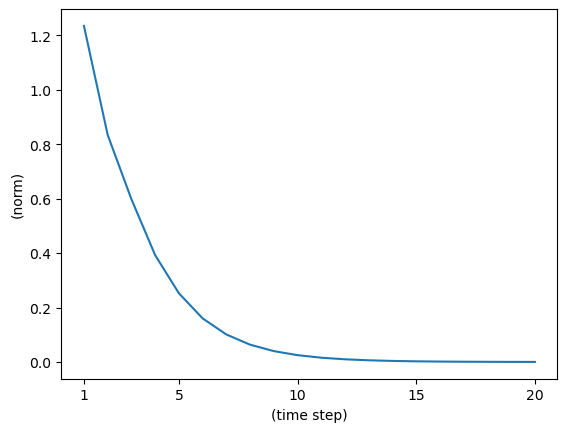

[2.4684068094579303, 3.3357049741610365, 4.783279375373182, 6.279587332087612, 8.080776465019053, 10.251163032292936, 12.936063506609896, 16.276861327786712, 20.45482961834598, 25.688972842084684, 32.25315718048336, 40.48895641683869, 50.8244073070191, 63.79612654485427, 80.07737014308985, 100.5129892205125, 126.16331847536823, 158.35920648258823, 198.7710796761195, 249.495615421267]


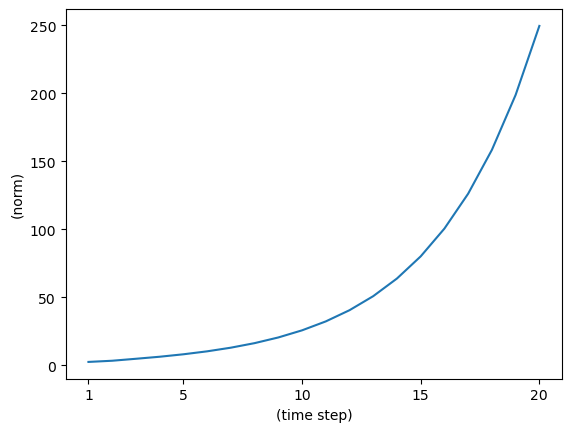

In [4]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


N = 2   # 미니배치 크기
H = 3   # 은닉 상태 벡터의 차원 수
T = 20  # 시계열 데이터의 길이

dh = np.ones((N, H))

np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정

#Wh = np.random.randn(H, H)
Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('(time step)')
plt.ylabel('(norm)')
plt.show()

dh = np.ones((N, H))

np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정

Wh = np.random.randn(H, H)
#Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('(time step)')
plt.ylabel('(norm)')
plt.show()



In [5]:
# 기울기 클리핑
# coding: utf-8
import numpy as np


dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after:', dW1.flatten())

before: [6.49144048 2.78487283 6.76254902 5.90862817 0.23981882 5.58854088
 2.59252447 4.15101197 2.83525082]
after: [1.49503731 0.64138134 1.55747605 1.36081038 0.05523244 1.28709139
 0.59708178 0.95601551 0.65298384]


In [6]:
# coding: utf-8
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9999.62
| 에폭 1 |  반복 21 / 1327 | 시간 2[s] | 퍼플렉서티 2977.73
| 에폭 1 |  반복 41 / 1327 | 시간 4[s] | 퍼플렉서티 1224.18
| 에폭 1 |  반복 61 / 1327 | 시간 7[s] | 퍼플렉서티 996.75
| 에폭 1 |  반복 81 / 1327 | 시간 9[s] | 퍼플렉서티 794.86
| 에폭 1 |  반복 101 / 1327 | 시간 12[s] | 퍼플렉서티 647.23
| 에폭 1 |  반복 121 / 1327 | 시간 14[s] | 퍼플렉서티 653.07
| 에폭 1 |  반복 141 / 1327 | 시간 16[s] | 퍼플렉서티 597.02
| 에폭 1 |  반복 161 / 1327 | 시간 19[s] | 퍼플렉서티 583.68
| 에폭 1 |  반복 181 / 1327 | 시간 21[s] | 퍼플렉서티 586.90
| 에폭 1 |  반복 201 / 1327 | 시간 24[s] | 퍼플렉서티 496.63
| 에폭 1 |  반복 221 / 1327 | 시간 26[s] | 퍼플렉서티 489.27
| 에폭 1 |  반복 241 / 1327 | 시간 28[s] | 퍼플렉서티 440.17
| 에폭 1 |  반복 261 / 1327 | 시간 31[s] | 퍼플렉서티 456.21
| 에폭 1 |  반복 281 / 1327 | 시간 33[s] | 퍼플렉서티 465.24
| 에폭 1 |  반복 301 / 1327 | 시간 36[s] | 퍼플렉서티 387.61
| 에폭 1 |  반복 321 / 1327 | 시간 38[s] | 퍼플렉서티 335.00
| 에폭 1 |  반복 341 / 1327 | 시간 40[s] | 퍼플렉서티 399.38
| 에폭 1 |  반복 361 / 1327 | 시간 43[s] | 퍼플렉서티 408.64
| 에폭 1 |  반복 381 / 1327 | 시간 45[s] | 퍼플렉서티 331.79
| 에폭 1 |

| 에폭 3 |  반복 561 / 1327 | 시간 385[s] | 퍼플렉서티 117.59
| 에폭 3 |  반복 581 / 1327 | 시간 387[s] | 퍼플렉서티 104.76
| 에폭 3 |  반복 601 / 1327 | 시간 389[s] | 퍼플렉서티 145.41
| 에폭 3 |  반복 621 / 1327 | 시간 392[s] | 퍼플렉서티 141.78
| 에폭 3 |  반복 641 / 1327 | 시간 394[s] | 퍼플렉서티 127.62
| 에폭 3 |  반복 661 / 1327 | 시간 397[s] | 퍼플렉서티 119.12
| 에폭 3 |  반복 681 / 1327 | 시간 399[s] | 퍼플렉서티 98.86
| 에폭 3 |  반복 701 / 1327 | 시간 401[s] | 퍼플렉서티 117.40
| 에폭 3 |  반복 721 / 1327 | 시간 404[s] | 퍼플렉서티 124.50
| 에폭 3 |  반복 741 / 1327 | 시간 406[s] | 퍼플렉서티 105.03
| 에폭 3 |  반복 761 / 1327 | 시간 409[s] | 퍼플렉서티 102.23
| 에폭 3 |  반복 781 / 1327 | 시간 411[s] | 퍼플렉서티 102.42
| 에폭 3 |  반복 801 / 1327 | 시간 413[s] | 퍼플렉서티 113.73
| 에폭 3 |  반복 821 / 1327 | 시간 416[s] | 퍼플렉서티 115.18
| 에폭 3 |  반복 841 / 1327 | 시간 418[s] | 퍼플렉서티 112.76
| 에폭 3 |  반복 861 / 1327 | 시간 421[s] | 퍼플렉서티 119.50
| 에폭 3 |  반복 881 / 1327 | 시간 423[s] | 퍼플렉서티 104.46
| 에폭 3 |  반복 901 / 1327 | 시간 426[s] | 퍼플렉서티 130.32
| 에폭 3 |  반복 921 / 1327 | 시간 428[s] | 퍼플렉서티 117.21
| 에폭 3 |  반복 941 / 1327 | 시간 430

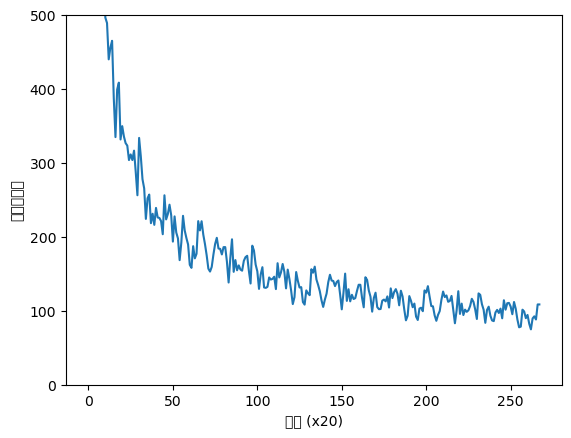

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  134.16861439129403


In [10]:
# coding: utf-8
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.RnnlmGen()

In [11]:
#1. LSTM 계층의 다층화
#2. 드롭아웃 사용
#3. 가중치 공유
# coding: utf-8
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    '''
     LSTM 계층을 2개 사용하고 각 층에 드롭아웃을 적용한 모델이다.
     아래 [1]에서 제안한 모델을 기초로 하였고, [2]와 [3]의 가중치 공유(weight tying)를 적용했다.

     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

In [13]:
# coding: utf-8
import sys
sys.path.append('..')
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ==============================================
# config.GPU = True
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from better_rnnlm import BetterRnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

| 에폭 1 |  반복 1 / 1327 | 시간 1[s] | 퍼플렉서티 9999.86
| 에폭 1 |  반복 21 / 1327 | 시간 24[s] | 퍼플렉서티 3972.39
| 에폭 1 |  반복 41 / 1327 | 시간 48[s] | 퍼플렉서티 1769.47
| 에폭 1 |  반복 61 / 1327 | 시간 71[s] | 퍼플렉서티 1277.37
| 에폭 1 |  반복 81 / 1327 | 시간 95[s] | 퍼플렉서티 1060.54
| 에폭 1 |  반복 101 / 1327 | 시간 118[s] | 퍼플렉서티 856.03
| 에폭 1 |  반복 121 / 1327 | 시간 142[s] | 퍼플렉서티 807.36
| 에폭 1 |  반복 141 / 1327 | 시간 166[s] | 퍼플렉서티 737.13
| 에폭 1 |  반복 161 / 1327 | 시간 190[s] | 퍼플렉서티 698.79
| 에폭 1 |  반복 181 / 1327 | 시간 214[s] | 퍼플렉서티 689.05
| 에폭 1 |  반복 201 / 1327 | 시간 238[s] | 퍼플렉서티 606.89
| 에폭 1 |  반복 221 / 1327 | 시간 262[s] | 퍼플렉서티 582.81
| 에폭 1 |  반복 241 / 1327 | 시간 286[s] | 퍼플렉서티 524.07
| 에폭 1 |  반복 261 / 1327 | 시간 310[s] | 퍼플렉서티 541.89
| 에폭 1 |  반복 281 / 1327 | 시간 334[s] | 퍼플렉서티 518.02
| 에폭 1 |  반복 301 / 1327 | 시간 358[s] | 퍼플렉서티 454.35
| 에폭 1 |  반복 321 / 1327 | 시간 382[s] | 퍼플렉서티 394.73
| 에폭 1 |  반복 341 / 1327 | 시간 406[s] | 퍼플렉서티 455.16
| 에폭 1 |  반복 361 / 1327 | 시간 430[s] | 퍼플렉서티 460.51
| 에폭 1 |  반복 381 / 1327 | 시간 454[s] | 

| 에폭 3 |  반복 441 / 1327 | 시간 521[s] | 퍼플렉서티 140.70
| 에폭 3 |  반복 461 / 1327 | 시간 546[s] | 퍼플렉서티 139.61
| 에폭 3 |  반복 481 / 1327 | 시간 570[s] | 퍼플렉서티 134.11
| 에폭 3 |  반복 501 / 1327 | 시간 594[s] | 퍼플렉서티 149.66
| 에폭 3 |  반복 521 / 1327 | 시간 618[s] | 퍼플렉서티 152.14
| 에폭 3 |  반복 541 / 1327 | 시간 642[s] | 퍼플렉서티 157.98
| 에폭 3 |  반복 561 / 1327 | 시간 666[s] | 퍼플렉서티 132.99
| 에폭 3 |  반복 581 / 1327 | 시간 691[s] | 퍼플렉서티 123.22
| 에폭 3 |  반복 601 / 1327 | 시간 715[s] | 퍼플렉서티 170.15
| 에폭 3 |  반복 621 / 1327 | 시간 739[s] | 퍼플렉서티 159.07
| 에폭 3 |  반복 641 / 1327 | 시간 763[s] | 퍼플렉서티 145.33
| 에폭 3 |  반복 661 / 1327 | 시간 787[s] | 퍼플렉서티 136.90
| 에폭 3 |  반복 681 / 1327 | 시간 811[s] | 퍼플렉서티 117.63
| 에폭 3 |  반복 701 / 1327 | 시간 835[s] | 퍼플렉서티 136.65
| 에폭 3 |  반복 721 / 1327 | 시간 858[s] | 퍼플렉서티 139.99
| 에폭 3 |  반복 741 / 1327 | 시간 882[s] | 퍼플렉서티 119.55
| 에폭 3 |  반복 761 / 1327 | 시간 906[s] | 퍼플렉서티 115.50
| 에폭 3 |  반복 781 / 1327 | 시간 930[s] | 퍼플렉서티 120.50
| 에폭 3 |  반복 801 / 1327 | 시간 954[s] | 퍼플렉서티 135.92
| 에폭 3 |  반복 821 / 1327 | 시간 97

KeyboardInterrupt: 